In [1]:
%load_ext autoreload
%autoreload 2

from dotenv import load_dotenv
import pandas as pd
import numpy as np
import os
import sys
import datetime

root_path = os.path.abspath(os.path.join('..'))
if root_path not in sys.path:
    sys.path.append(root_path)
    
load_dotenv()

True

In [2]:
# load datasets
from training.utils import date_range, preprocess_c

df_train = pd.concat([
    pd.read_csv(f'../datasets/d{d.strftime("%Y-%m-%d")}.csv') for d in date_range(
        datetime.date(2019, 11, 1), 
        datetime.date(2020, 2, 1),
        datetime.timedelta(days=1),
    )
])
df_val = pd.concat([
    pd.read_csv(f'../datasets/d{d.strftime("%Y-%m-%d")}.csv') for d in date_range(
        datetime.date(2020, 2, 1), 
        datetime.date(2020, 2, 15),
        datetime.timedelta(days=1),
    )
])

X1_train, X2_train, y_train = preprocess_c(df_train)
X1_val, X2_val, y_val = preprocess_c(df_val)

X1_train.shape, X2_train.shape, y_train.shape, X1_val.shape, X2_val.shape, y_val.shape

((1598125, 1, 4),
 (1598125, 14, 4),
 (1598125, 4),
 (263845, 1, 4),
 (263845, 14, 4),
 (263845, 4))

In [3]:
# model structure
from keras.models import Model, clone_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

prev_days = int(os.getenv('PREV_DAYS'))

visible1 = Input(shape=(1, 4))
cnn1 = Conv1D(filters=64, kernel_size=1, activation='relu')(visible1)
cnn1 = MaxPooling1D(pool_size=1)(cnn1)
cnn1 = Flatten()(cnn1)

visible2 = Input(shape=(prev_days, 4))
cnn2 = Conv1D(filters=64, kernel_size=3, activation='relu')(visible2)
cnn2 = MaxPooling1D(pool_size=2)(cnn2)
cnn2 = Flatten()(cnn2)

merge = concatenate([cnn1, cnn2])
dense = Dense(8, activation='relu')(merge)
output = Dense(1, activation=LeakyReLU(alpha=0.01))(dense)
model = Model(inputs=[visible1, visible2], outputs=output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 4)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 14, 4)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 1, 64)        320         ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 12, 64)       832         ['input_2[0][0]']                
                                                                                              

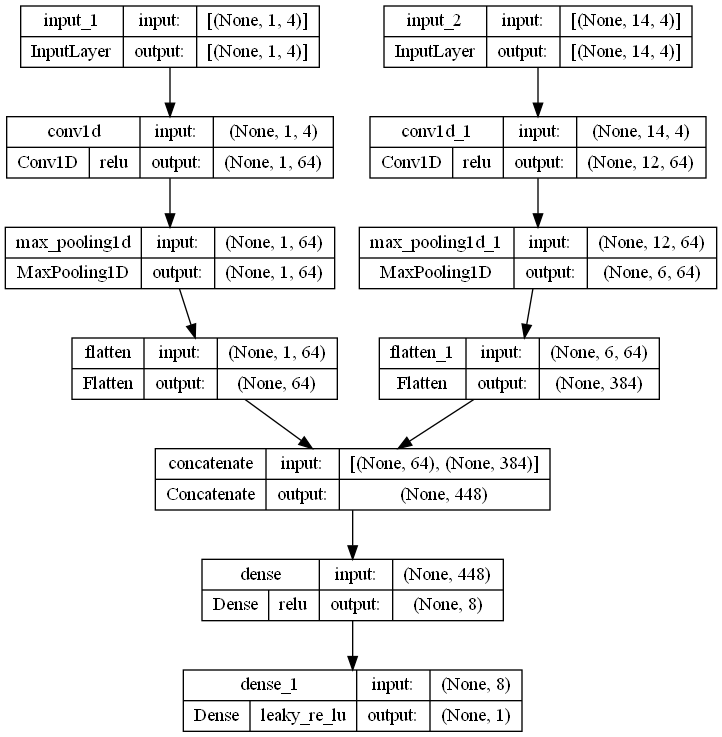

In [4]:
# plot model
from keras.utils import plot_model

plot_model(model,to_file='../.data/model_c.png', show_layer_activations=True, show_shapes=True, show_layer_names=True)

In [5]:
# train view
model_view = clone_model(model)
cp_view = ModelCheckpoint('../model/c-view.keras', save_best_only=True)
model_view.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model_view.fit([X1_train, X2_train], y_train[:, 0], validation_data=([X1_val, X2_val], y_val[:, 0]), epochs=4, callbacks=[cp_view])

Epoch 1/4
49942/49942 [==============================] - 105s 2ms/step - loss: 0.2186 - root_mean_squared_error: 0.4676 - val_loss: 0.9945 - val_root_mean_squared_error: 0.9973
Epoch 2/4
49942/49942 [==============================] - 97s 2ms/step - loss: 0.1854 - root_mean_squared_error: 0.4306 - val_loss: 0.9789 - val_root_mean_squared_error: 0.9894
Epoch 3/4
49942/49942 [==============================] - 101s 2ms/step - loss: 0.1750 - root_mean_squared_error: 0.4183 - val_loss: 0.9475 - val_root_mean_squared_error: 0.9734
Epoch 4/4
49942/49942 [==============================] - 100s 2ms/step - loss: 0.1699 - root_mean_squared_error: 0.4122 - val_loss: 0.9335 - val_root_mean_squared_error: 0.9662


In [6]:
# train cart
model_cart = clone_model(model)
cp_cart = ModelCheckpoint('../model/c-cart.keras', save_best_only=True)
model_cart.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model_cart.fit([X1_train, X2_train], y_train[:, 1], validation_data=([X1_val, X2_val], y_val[:, 1]), epochs=4, callbacks=[cp_cart])

Epoch 1/4
49942/49942 [==============================] - 115s 2ms/step - loss: 0.3362 - root_mean_squared_error: 0.5798 - val_loss: 0.4095 - val_root_mean_squared_error: 0.6399
Epoch 2/4
49942/49942 [==============================] - 103s 2ms/step - loss: 0.3016 - root_mean_squared_error: 0.5492 - val_loss: 0.4072 - val_root_mean_squared_error: 0.6381
Epoch 3/4
49942/49942 [==============================] - 99s 2ms/step - loss: 0.2935 - root_mean_squared_error: 0.5417 - val_loss: 0.4417 - val_root_mean_squared_error: 0.6646
Epoch 4/4
49942/49942 [==============================] - 102s 2ms/step - loss: 0.2877 - root_mean_squared_error: 0.5364 - val_loss: 0.4155 - val_root_mean_squared_error: 0.6446


In [7]:
# train remove_from_cart
model_remove_from_cart = clone_model(model)
cp_remove_from_cart = ModelCheckpoint('../model/c-remove_from_cart.keras', save_best_only=True)
model_remove_from_cart.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model_remove_from_cart.fit([X1_train, X2_train], y_train[:, 2], validation_data=([X1_val, X2_val], y_val[:, 2]), epochs=4, callbacks=[cp_remove_from_cart])

Epoch 1/4
49942/49942 [==============================] - 114s 2ms/step - loss: 0.4715 - root_mean_squared_error: 0.6867 - val_loss: 0.5625 - val_root_mean_squared_error: 0.7500
Epoch 2/4
49942/49942 [==============================] - 112s 2ms/step - loss: 0.4355 - root_mean_squared_error: 0.6599 - val_loss: 0.5479 - val_root_mean_squared_error: 0.7402
Epoch 3/4
49942/49942 [==============================] - 103s 2ms/step - loss: 0.4293 - root_mean_squared_error: 0.6552 - val_loss: 0.5480 - val_root_mean_squared_error: 0.7402
Epoch 4/4
49942/49942 [==============================] - 104s 2ms/step - loss: 0.4267 - root_mean_squared_error: 0.6532 - val_loss: 0.5514 - val_root_mean_squared_error: 0.7425


In [8]:
# train purchase
model_purchase = clone_model(model)
cp_purchase = ModelCheckpoint('../model/c-purchase.keras', save_best_only=True)
model_purchase.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model_purchase.fit([X1_train, X2_train], y_train[:, 3], validation_data=([X1_val, X2_val], y_val[:, 3]), epochs=4, callbacks=[cp_purchase])

Epoch 1/4
49942/49942 [==============================] - 106s 2ms/step - loss: 0.4636 - root_mean_squared_error: 0.6809 - val_loss: 0.3378 - val_root_mean_squared_error: 0.5812
Epoch 2/4
49942/49942 [==============================] - 100s 2ms/step - loss: 0.4325 - root_mean_squared_error: 0.6576 - val_loss: 0.3507 - val_root_mean_squared_error: 0.5922
Epoch 3/4
49942/49942 [==============================] - 104s 2ms/step - loss: 0.4242 - root_mean_squared_error: 0.6513 - val_loss: 0.4085 - val_root_mean_squared_error: 0.6391
Epoch 4/4
49942/49942 [==============================] - 103s 2ms/step - loss: 0.4185 - root_mean_squared_error: 0.6469 - val_loss: 0.3558 - val_root_mean_squared_error: 0.5965
